In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from pathlib import Path

comp = 'state-farm-distracted-driver-detection'

path = setup_comp(comp)
output_path = Path("/kaggle/working/")
list(path.glob("*"))

import pandas as pd
from fastai.vision.all import *
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from IPython.display import Image


In [2]:
train_meta = pd.read_csv(path / "driver_imgs_list.csv")
print(train_meta.info())
train_meta["img"] =  path / "imgs" / "train" / train_meta.classname / train_meta.img
train_meta.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


,subject,classname,img
0,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_44733.jpg
1,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_72999.jpg
2,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_25094.jpg
3,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_69092.jpg
4,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_92629.jpg


In [3]:
pose_name_to_desc = {
    "c0": "normal_driving",
    "c1": "texting_right",
    "c2": "talking_on_the_phone_right",
    "c3": "texting_left",
    "c4": "talking_on_the_phone_left",
    "c5": "operating_the_radio",
    "c6": "drinking",
    "c7": "reaching_behind",
    "c8": "hair_and_makeup",
    "c9": "talking_to_passenger"   
}
train_meta["classdesc"] = train_meta.classname.map(pose_name_to_desc)
train_meta.head()


,subject,classname,img,classdesc
0,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_44733.jpg,normal_driving
1,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_72999.jpg,normal_driving
2,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_25094.jpg,normal_driving
3,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_69092.jpg,normal_driving
4,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_92629.jpg,normal_driving


In [4]:
def get_classdesc_label(path):
    """Get descriptive label from classname using mapping dict."""
    classname = path.parent.name  # Gets "c0", "c1", etc from folder
    return pose_name_to_desc[classname]

def create_split_column(df, subject_col='subject', valid_pct=0.3):
    df = df.copy()
    subjects = df[subject_col].unique()
    n_valid = int(len(subjects) * valid_pct)
    valid_subjects = np.random.choice(subjects, n_valid, replace=False)
    df['is_valid'] = df[subject_col].isin(valid_subjects)  # True = valid, False = train
    return df
    
train_meta = create_split_column(train_meta, valid_pct=0.3)
train_meta.head()


,subject,classname,img,classdesc,is_valid
0,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_44733.jpg,normal_driving,False
1,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_72999.jpg,normal_driving,False
2,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_25094.jpg,normal_driving,False
3,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_69092.jpg,normal_driving,False
4,p002,c0,../input/state-farm-distracted-driver-detection/imgs/train/c0/img_92629.jpg,normal_driving,False


In [5]:
sample_size = 100
sample = train_meta.groupby('subject').apply(lambda x: x.sample(sample_size), include_groups=True)
sample.subject.value_counts()


/tmp/ipykernel_19/1013874716.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = train_meta.groupby('subject').apply(lambda x: x.sample(sample_size), include_groups=True)


subject
p002    100
p012    100
p014    100
p015    100
p016    100
p021    100
p022    100
p024    100
p026    100
p035    100
p039    100
p041    100
p042    100
p045    100
p047    100
p049    100
p050    100
p051    100
p052    100
p056    100
p061    100
p064    100
p066    100
p072    100
p075    100
p081    100
Name: count, dtype: int64

Training images: 1900
Validation images: 700
Total images: 2600

Train/Valid split ratio: 73.1% / 26.9%


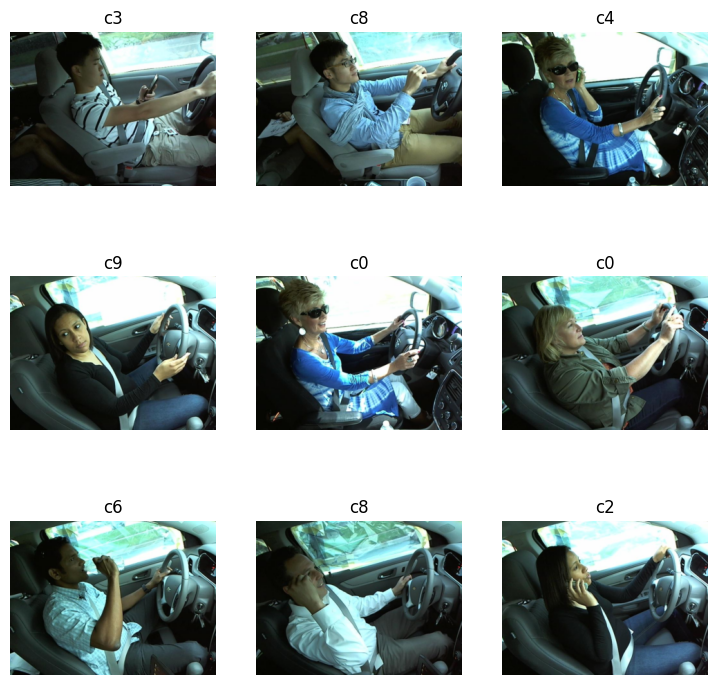

In [6]:
aspect_ratio = 1.3333333333333333
img_size = 224
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock
from fastai.data.transforms import ColReader, ColSplitter

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('img'),
    get_y=ColReader('classname'),
    splitter=ColSplitter(),
    item_tfms=Resize((img_size, int(img_size * aspect_ratio))),
    batch_tfms=[]
)
dls = dblock.dataloaders(sample, bs=32)
dls.show_batch()

print(f"Training images: {len(dls.train_ds)}")
print(f"Validation images: {len(dls.valid_ds)}")
print(f"Total images: {len(dls.train_ds) + len(dls.valid_ds)}")

# More detailed breakdown
print(f"\nTrain/Valid split ratio: {len(dls.train_ds)/(len(dls.train_ds) + len(dls.valid_ds)):.1%} / {len(dls.valid_ds)/(len(dls.train_ds) + len(dls.valid_ds)):.1%}")


In [7]:
learn = vision_learner(
    dls, 
    resnet50, 
    metrics=[accuracy, error_rate],
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.317999,1.428195,0.572857,0.427143,00:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.248712,1.019850,0.708571,0.291429,00:16
1,0.205380,0.860446,0.775714,0.224286,00:16
2,0.284128,0.896049,0.834286,0.165714,00:16
3,0.188720,0.602041,0.854286,0.145714,00:16
4,0.144212,0.830455,0.828571,0.171429,00:16
5,0.081618,0.718096,0.820000,0.180000,00:16
6,0.034170,0.682840,0.818571,0.181429,00:16
7,0.018711,0.498715,0.888571,0.111429,00:16
8,0.014117,0.468087,0.884286,0.115714,00:16
9,0.011163,0.454292,0.885714,0.114286,00:16


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

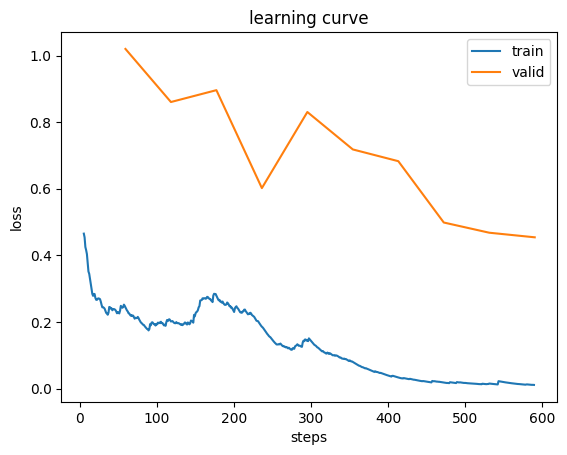

In [8]:
learn.fine_tune(10, 0.01)
learn.recorder.plot_loss()


In [9]:
preds, targets = learn.get_preds(dl=dls.valid)
loss = nn.functional.cross_entropy(torch.log(preds), targets)
print(f"Basic cross entropy loss: {loss:.3f}")


Basic cross entropy loss: 0.454


In [10]:
test_path = path / "imgs" / "test" 
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)
test_preds, _ = learn.get_preds(dl=test_dl)

print(f"Test predictions shape: {test_preds.shape}")
print(f"Number of test images: {len(test_files)}")


Test predictions shape: torch.Size([79726, 10])
Number of test images: 79726


In [11]:
class_names = learn.dls.vocab
print(f"Classes: {class_names}")
test_image_names = [f.name for f in test_files]


submission = pd.DataFrame({
    'img': test_image_names,
})
# add porbs for each class
for i, class_name in enumerate(class_names):
    submission[class_name] = test_preds[:, i].cpu().numpy()

print("Submission head:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
# check probs add up to one
print(f"Probabilities sum check (should be ~1.0): {submission[class_names].sum(axis=1).head()}")


Classes: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Submission head:
             img            c0            c1            c2            c3  \
0  img_96590.jpg  2.334675e-13  1.029602e-12  4.263011e-12  1.062528e-13   
1  img_32366.jpg  1.738164e-08  1.122534e-09  2.064844e-09  3.563575e-09   
2  img_99675.jpg  8.076288e-07  5.900343e-05  2.204213e-06  6.534221e-06   
3  img_85937.jpg  3.805662e-05  3.724571e-06  7.052743e-08  6.432929e-06   
4  img_73903.jpg  7.350604e-09  6.966309e-08  5.490520e-09  4.338913e-09   

             c4            c5            c6            c7            c8  \
0  2.277918e-14  1.326817e-13  3.415654e-11  7.351063e-14  1.000000e+00   
1  4.270888e-08  9.999998e-01  7.315553e-09  5.765319e-09  7.196835e-09   
2  6.025134e-07  2.004324e-06  9.999161e-01  2.917133e-06  9.768493e-06   
3  4.094240e-06  9.989287e-01  1.219524e-06  9.671833e-07  5.192596e-06   
4  2.471804e-09  2.177543e-09  7.527402e-09  9.999999e-01  4.033605e-08   

     

In [12]:
submission_path = output_path / Path("submission.csv")
print(f"Submission path: {submission_path}")
submission.to_csv(submission_path, index=False)
# check submission saved ok!
!head -5 {submission_path}


Submission path: /kaggle/working/submission.csv
img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_96590.jpg,2.3346752e-13,1.0296022e-12,4.2630105e-12,1.0625279e-13,2.2779177e-14,1.3268167e-13,3.415654e-11,7.351063e-14,1.0,3.816678e-11
img_32366.jpg,1.7381637e-08,1.1225335e-09,2.064844e-09,3.5635752e-09,4.270888e-08,0.99999976,7.3155526e-09,5.7653193e-09,7.196835e-09,8.5783036e-08
img_99675.jpg,8.076288e-07,5.900343e-05,2.2042134e-06,6.5342206e-06,6.0251335e-07,2.0043235e-06,0.9999161,2.9171329e-06,9.768493e-06,1.1267338e-07
img_85937.jpg,3.8056623e-05,3.7245713e-06,7.052743e-08,6.4329292e-06,4.09424e-06,0.9989287,1.2195238e-06,9.671833e-07,5.1925963e-06,0.0010115195
